# "Forecasting with Machine Learning models"
> "**mlforecast** makes forecasting with machine learning models easy."

- toc: true
- branch: main
- badges: true
- comments: true
- author: José Morales
- categories: [machine learning, forecasting]
- image: images/nixtla_logo.png

## Introduction

In this post I'll talk about using machine learning models in forecasting tasks. I'll use an example to show what the main challanges are and then I'll introduce [mlforecast](https://github.com/Nixtla/mlforecast), a framework that facilitates using machine learning models in forecasting. **mlforecast** does the feature engineering and takes care of the updates for you, you only have to provide a regressor that follows the scikit-learn API (implements fit and predict) and specify the features that you want to use which can be lags, lag-based transformations and date features.

## Motivation

For many years classical methods like ARIMA and ETS dominated the forecasting field. One of the reasons was that most of the use cases involved forecasting low frequency series like monthly, quarterly or yearly. Furthermore, there weren't many distinct time series to forecast, so fitting a single model to each one and getting forecasts from them was straightforward.

In recent years, there has been a rise in the need to forecast more time series and with higher frequencies. This imposes a challenge because classical methods aren't mean to model several time series together, so using them is suboptimal because it takes more time (you have to train many models) and there could be some common patterns between the series that could be learned by modeling them together.

In order to address this problem there have been various efforts in proposing different methods that can train a single model on many time series. Some very interesting deep learning architectures have been designed that can accurately forecast many time series like ESRNN, DeepAR, NBEATS among others.

Traditional machine learning models like gradient boosted trees have been used as well and have shown that they can achieve very good performance as well. However, using these models with lag-based features isn't very straightforward because you have to update your features in every timestep in order to compute the predictions. Additionally, depending on your forecasting horizon and the lags that you use, at some point you run out of real values of your series to update your features, so you have to do something to fill those gaps. One possible approach is using your predictions as the values for the serie and update your features using them, which is what **mlforecast** does.

## Example

In the following section I'll show a very simple example with a single serie to highlight the difficulties in using machine learning models in forecasting tasks.

### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

### Data

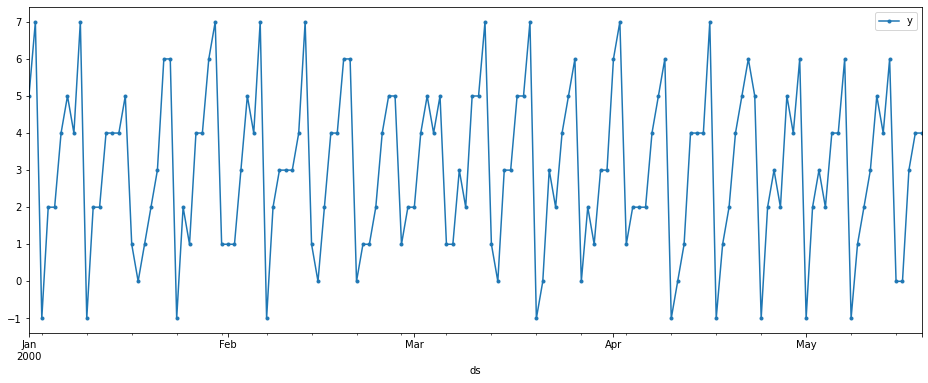

In [2]:
rng = np.random.RandomState(90)
serie_length = 7 * 20
dates = pd.date_range('2000-01-01', freq='D', periods=serie_length, name='ds')
y = dates.dayofweek + rng.randint(-1, 2, size=dates.size)
data = pd.DataFrame({'y': y.astype(np.float64)}, index=dates)
data.plot(marker='.', figsize=(16, 6));

Our data has daily seasonality and as you can see in the creation, it is basically just dayofweek + Uniform({-1, 0, 1}).

### Training

Let's say we want forecasts for the next 14 days, the first step would be deciding which model and features to use, so we'll create a validation set containing the last 14 days in our data.

In [3]:
valid_horizon = 14
train = data.head(-valid_horizon).copy()
y_valid = data.tail(valid_horizon)['y']

As a starting point, we'll try lag 7 and lag 14.

In [4]:
train['lag-7'] = train['y'].shift(7)
train['lag-14'] = train['y'].shift(14)

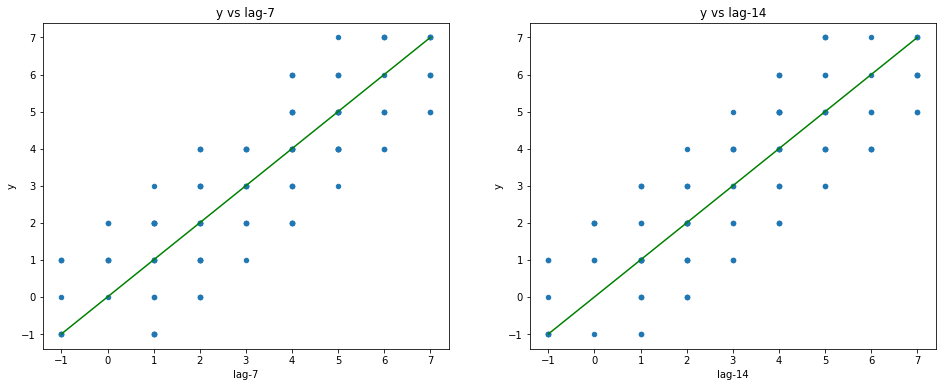

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='y', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'y vs lag-{lag}')

We can see the expected relationship between the lags and the target. For example, when *lag-7* is 2, *y* can be either 0, 1, 2, 3 or 4. This is because every day of the week can have the values [day - 1, day, day + 1], so when we're at the day of the week number 2, we can get values 1, 2 or 3. However the value 2 can come from day of the week 1, whose minimum is 0, and it can come from the day of the week 3, whose maximum is 4.

Computing lag values leaves some rows with nulls.

In [6]:
train.isnull().sum()

y          0
lag-7      7
lag-14    14
dtype: int64

We'll drop these before training.

In [7]:
train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='y')
y_train = train_without_nulls['y']

We'll train a linear regression without intercept. Since the best model would be taking the average for each day of the week, we expect to get coefficients that are close to 0.5.

In [8]:
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.5136953 , 0.44695162])

This model is taking $0.51 \cdot lag_7 + 0.45 \cdot lag_{14}$.

### Forecasting

Great. So now that we have our trained model, how can we compute the forecasts for the next 14 days? Machine learning models a feature matrix *X* and output the predicted values *y*. So we need to create the feature matrix *X* for the next 14 days and give it to our model.

If we want to get the *lag-7* for the next day following the training set we can just get the value in the 7th position starting from the end. The *lag-7* two days after the end of the training set would be the value in the 6th position starting from the end and so on. Similarly for the *lag-14*.

In [9]:
next_lags_7 = y_train.tail(7).values
next_lags_7

array([ 4.,  6., -1.,  2.,  3.,  2.,  4.])

In [10]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([ 6.,  5., -1.,  2.,  3.,  2.,  5.,  4.,  6., -1.,  2.,  3.,  2.,
        4.])

As you may have noticed we can only get 7 of the *lag-7* values from our history and we can get all 14 values for the *lag-14*. With this information we can only forecast the next 7 days, so we'll only take the first 7 values of the *lag-14*.

In [11]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

,lag-7,lag-14
0,4.0,6.0
1,6.0,5.0
2,-1.0,-1.0
3,2.0,2.0
4,3.0,3.0
5,2.0,2.0
6,4.0,5.0


With these features we can compute the forecasts for the next 7 days.

In [12]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928])

These values can be interpreted as the values of our series for the next 7 days following the last training date. In order to compute the forecasts following that date we can use these values as if they were the values of our series and use them as *lag-7* for the following periods.

In other words, we can fill the rest of our features matrix with these values and the real values of the *lag-14*.

In [13]:
X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

,lag-7,lag-14
0,4.736491,4.0
1,5.316930,6.0
2,-0.960647,-1.0
3,1.921294,2.0
4,2.881941,3.0
5,1.921294,2.0
6,4.289539,4.0


As you can see we're still using the real values of the *lag-14* and we've plugged in our predictions as the values for the *lag-7*. We can now use these features to predict the remaining 7 days.

In [14]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928,  4.22091958,  5.41299159, -0.94043142,
        1.88086285,  2.82129427,  1.88086285,  3.99132264])

And now we have our forecasts for the next 14 days! This wasn't that painful but it wasn't pretty either. And we just used lags which are the easiest feature we can have because you just have to shift your data.

What if we had used *lag-1*? We would have needed to do this predict-update step 14 times!

And what if we had more elaborate features like the rolling mean over some lag?  As you can imagine it can get quite messy and is very error prone.

## mlforecast

With these problems in mind I created [mlforecast](https://github.com/Nixtla/mlforecast), which is a framework to help you forecast time series using machine learning models. It takes care of all the details for you, you just need to give it a model and which features you want to use and let it do the rest.

**mlforecast** is available in [PyPI](https://pypi.org/project/mlforecast/)

In [15]:
#!pip install mlforecast

As well as [conda-forge](https://anaconda.org/conda-forge/mlforecast)

In [16]:
#!conda install -c conda-forge mlforecast

The problem in the example can be solved using **mlforecast** with the following lines.

First we have to set up our data in the required format.

In [17]:
train_mlfcst = train.reset_index()[['ds', 'y']]
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst.head()

,ds,y
unique_id,,
0,2000-01-01,5.0
0,2000-01-02,7.0
0,2000-01-03,-1.0
0,2000-01-04,2.0
0,2000-01-05,2.0


This is the required input format.
* an index named **unique_id** that identifies each time serie. In this case we only have one but you can have as many as you want.
* a **ds** column with the dates.
* a **y** column with the values.

Now we'll import the [TimeSeries](https://nixtla.github.io/mlforecast/core.html#TimeSeries) transformer, where we define the features that we want to use. We'll also import the [Forecast](https://nixtla.github.io/mlforecast/forecast.html#Forecast) class, which will hold our transformer and model and will run the forecasting pipeline for us.

In [18]:
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast

We initialize our transformer specifying the lags that we want to use.

In [19]:
ts = TimeSeries(lags=[7, 14])
ts

TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=8)

As you can see this transformer will use *lag-7* and *lag-14* as features. Now we define our model.

In [20]:
model = LinearRegression(fit_intercept=False)

We create a [Forecast](https://nixtla.github.io/mlforecast/forecast.html) object with the model and the time series transformer and fit it to our data.

In [21]:
fcst = Forecast(model, ts)
fcst.fit(train_mlfcst)

Forecast(model=LinearRegression(fit_intercept=False), ts=TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=8))

And now we just call predict with the forecast horizon that we want.

In [22]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

,ds,y_pred
unique_id,,
0,2000-05-06,4.736491
0,2000-05-07,5.316930
0,2000-05-08,-0.960647
0,2000-05-09,1.921294
0,2000-05-10,2.881941
0,2000-05-11,1.921294
0,2000-05-12,4.289539
0,2000-05-13,4.220920
0,2000-05-14,5.412992


Internally this did the same as we did before, which we can verify real quick.

Check that we got the same predictions:

In [23]:
np.testing.assert_equal(y_pred, y_pred_mlfcst['y_pred'].values)

Check that we got the same model:

In [24]:
np.testing.assert_equal(lr.coef_, fcst.model.coef_)

### Easier experiments

Having this high level abstraction allows us to focus on defining the best features and model instead of worrying about implementation details. For example, we can try out different lags very easily:

In [25]:
def evaluate_lags(lags):
    ts = TimeSeries(lags=lags)
    model = LinearRegression(fit_intercept=False)
    fcst = Forecast(model, ts)
    fcst.fit(train_mlfcst)
    print(*[f'lag-{lag:<2} coef: {fcst.model.coef_[i]:.2f}' for i, lag in enumerate(lags)], sep='\n')
    y_pred = fcst.predict(14)
    mse = mean_squared_error(y_valid, y_pred['y_pred'])
    print(f'MSE: {mse:.2f}')

In [26]:
evaluate_lags([7, 14])

lag-7  coef: 0.51
lag-14 coef: 0.45
MSE: 0.97


In [27]:
evaluate_lags([7, 14, 21])

lag-7  coef: 0.39
lag-14 coef: 0.31
lag-21 coef: 0.29
MSE: 0.74


In [28]:
evaluate_lags([7, 14, 21, 28])

lag-7  coef: 0.30
lag-14 coef: 0.18
lag-21 coef: 0.10
lag-28 coef: 0.41
MSE: 0.40


### Backtesting
In the previous examples we manually split our data. The **Forecast** object also has a [backtest](https://nixtla.github.io/mlforecast/forecast.html#Backtesting) method that can do that for us.

We'll first get all of our data into the required format.

In [29]:
data_mlfcst = data.reset_index()
data_mlfcst.index = pd.Index(np.repeat(0, data_mlfcst.shape[0]), name='unique_id')
data_mlfcst

,ds,y
unique_id,,
0,2000-01-01,5.0
0,2000-01-02,7.0
0,2000-01-03,-1.0
0,2000-01-04,2.0
0,2000-01-05,2.0
...,...,...
0,2000-05-15,0.0
0,2000-05-16,0.0
0,2000-05-17,3.0


Now we instantiate a `Forecast` object as we did previously and call the `backtest` method instead.

In [30]:
backtest_fcst = Forecast(
    LinearRegression(fit_intercept=False), TimeSeries(lags=[7, 14])
)
backtest_results = backtest_fcst.backtest(data_mlfcst, n_windows=2, window_size=14)

This returns a generator with the results for each window.

In [31]:
type(backtest_results)

generator

In [32]:
result1 = next(backtest_results)
result1

,ds,y,y_pred
unique_id,,,
0,2000-04-22,6.0,4.324606
0,2000-04-23,5.0,6.312634
0,2000-04-24,-1.0,-0.967022
0,2000-04-25,2.0,0.510503
0,2000-04-26,3.0,1.477525
0,2000-04-27,2.0,3.868087
0,2000-04-28,5.0,4.378590
0,2000-04-29,4.0,4.033799
0,2000-04-30,6.0,6.418250


In [33]:
result2 = next(backtest_results)
result2

,ds,y,y_pred
unique_id,,,
0,2000-05-06,4.0,4.736491
0,2000-05-07,6.0,5.316930
0,2000-05-08,-1.0,-0.960647
0,2000-05-09,1.0,1.921294
0,2000-05-10,2.0,2.881941
0,2000-05-11,3.0,1.921294
0,2000-05-12,5.0,4.289539
0,2000-05-13,4.0,4.220920
0,2000-05-14,6.0,5.412992


`result2` here is the same as the evaluation we did manually.

In [34]:
np.testing.assert_equal(result2['y_pred'].values, y_pred_mlfcst['y_pred'].values)

We can define a validation scheme for different lags using several windows.

In [35]:
def backtest(ts, model=None):
    if model is None:
        model = LinearRegression(fit_intercept=False)
    fcst = Forecast(model, ts)
    backtest_results = fcst.backtest(data_mlfcst, n_windows=4, window_size=14)
    mses = []
    results = []
    for i, result in enumerate(backtest_results):
        mses.append(mean_squared_error(result['y'], result['y_pred']))
        results.append(result.rename(columns={'y_pred': f'split-{i}'}))
    pd.concat(results).set_index('ds').plot(marker='.', figsize=(16, 6))
    print('Splits MSE:', np.round(mses, 2))
    print(f'Mean MSE: {np.mean(mses):.2f}')

Splits MSE: [1.36 1.52 1.43 0.97]
Mean MSE: 1.32


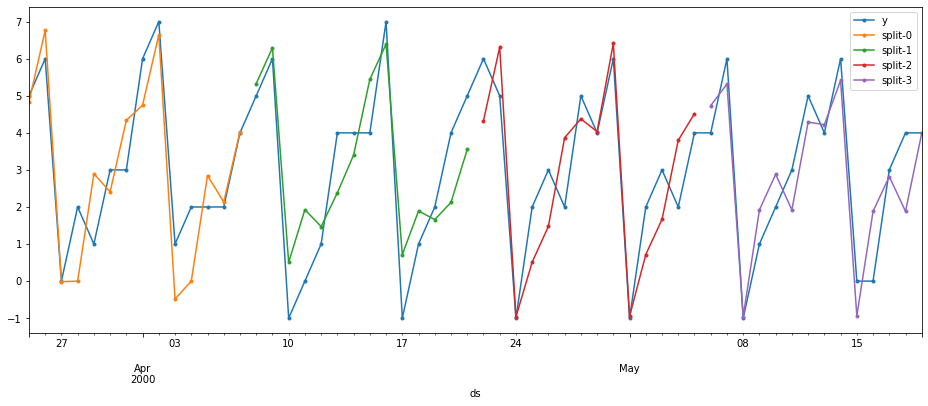

In [36]:
backtest(TimeSeries(lags=[7, 14]))

Splits MSE: [1.29 1.23 1.25 0.74]
Mean MSE: 1.13


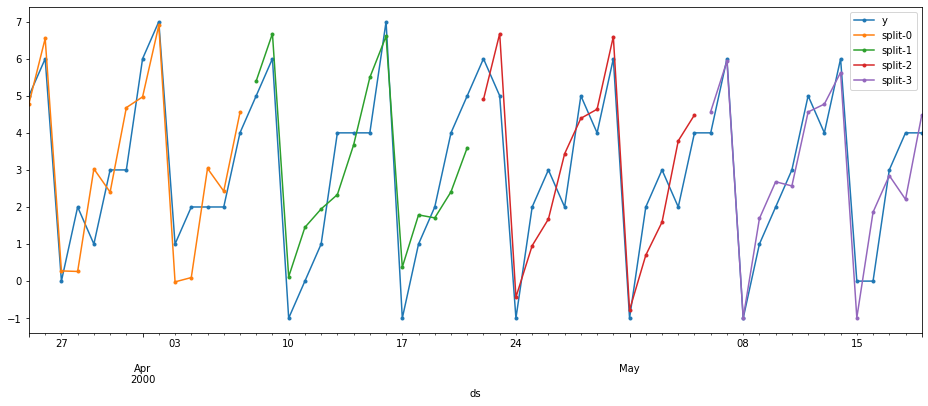

In [37]:
backtest(TimeSeries(lags=[7, 14, 21]))

Splits MSE: [0.97 1.1  1.13 0.4 ]
Mean MSE: 0.90


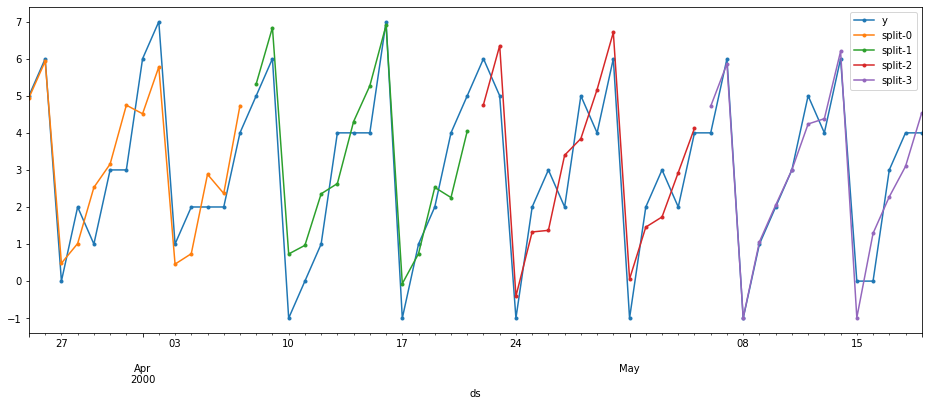

In [38]:
backtest(TimeSeries(lags=[7, 14, 21, 28]))

### Lag transformations
We can specify transformations on the lags as well as just lags. The [window_ops](https://github.com/jose-moralez/window_ops) library has some implementations of different window functions. You can also define your own transformations.

Let's try a seasonal rolling mean, this takes the average over the last `n` seasons, in this case it would be the average of the last `n` mondays, tuesdays, etc. Computing the updates for this feature would probably be a bit annoying, however using this framework we can just pass it to *lag_transforms*. If the transformations takes additional arguments (additional to the values of the serie) we specify a tuple like `(transform_function, arg1, arg2)`, which in this case are `season_length` and `window_size`.

In [39]:
from window_ops.rolling import seasonal_rolling_mean

In [40]:
help(seasonal_rolling_mean)

Help on CPUDispatcher in module window_ops.rolling:

seasonal_rolling_mean(input_array: numpy.ndarray, season_length: int, window_size: int, min_samples: Union[int, NoneType] = None) -> numpy.ndarray
    Compute the seasonal_rolling_mean over the last non-na window_size samples of the
    input array starting at min_samples.



*lag_transforms* takes a dictionary where the keys are the lags that we want to apply the transformations to and the values are the transformations themselves.

Splits MSE: [0.71 0.91 0.86 0.54]
Mean MSE: 0.75


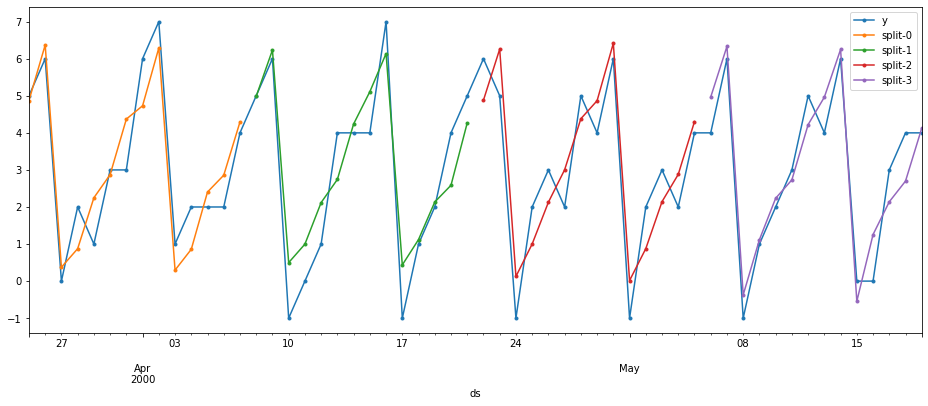

In [41]:
ts = TimeSeries(
    lag_transforms={
        7: [(seasonal_rolling_mean, 7, 8)]
    }
)
backtest(ts)

### Date features
You can also specify date features to be computed, which are attributes of the **ds** column and are updated in each timestep as well. In this example the best model would be taking the average over each day of the week, which can be accomplished by doing one hot encoding on the day of the week column and fitting a linear model.

Splits MSE: [0.6  0.61 0.95 0.5 ]
Mean MSE: 0.67


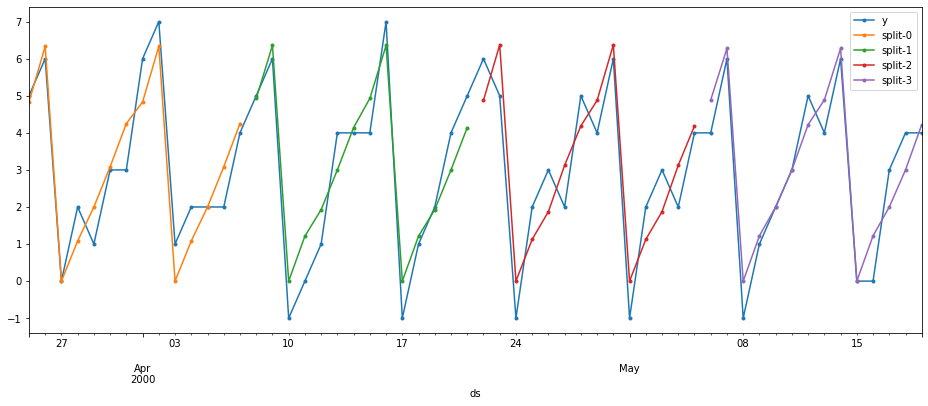

In [42]:
ts = TimeSeries(date_features=['dayofweek'])
model = make_pipeline(
    OneHotEncoder(drop='first'), LinearRegression(fit_intercept=False)
)
backtest(ts, model)

## Summary

In this post I presented **mlforecast**, a framework to use machine learning models in forecasting tasks. It allows you to focus on the model and features instead of implementation details. It has built-in backtesting to help you find the best performing model.

Although this example contained only a single time serie it is able to handle thousands of them and is very efficient both time and memory wise.

## Next steps
**mlforecast** has more features like [distributed training](https://nixtla.github.io/mlforecast/distributed.forecast.html#Example) and a [CLI](https://nixtla.github.io/mlforecast/cli.html#Example). If you're interested you can learn more in the following resources:
* GitHub repo: https://github.com/Nixtla/mlforecast
* Documentation: https://nixtla.github.io/mlforecast/
* Example using mlforecast in the M5 competition: https://www.kaggle.com/lemuz90/m5-mlforecast